# Imports

In [1]:
import numpy as np
import soundfile as sf

# Load audio file

In [2]:
#read input files as np array, assuming audio is stereo
file_name = "16bit_44.1khz_wav.wav"
#each sample value is from -1 to 1
audio_data, sample_rate = sf.read(file_name)
frame_count = len(audio_data)
#if training examples are of the same length, we can just calculate this once for the first training example
#split to 3 segments: start, middle and end
segment_frame_count = int(frame_count / 3)
audio_data_middle = audio_data[segment_frame_count : segment_frame_count * 2]

# Noise types

In [3]:
from enum import Enum
class Noise(Enum):
    GAUSSIAN = 1
    WHITE = 2
#change the noise type here
noise_type = Noise.GAUSSIAN

# Gaussian noise

Used in the forward process of Denoising Diffusion Probabilistic Model. Good simulation of noises in nature, easy to implement with Numpy.
Gaussian distribution is also closed under linear operations, potentially allowing the models to learn the pattern more easily.

In [4]:
#Hyperparameters: noise dynamic range, range factor that controls how much of the signal is in the range
def noise_gen_gaussian_stereo(range_factor, frame_count):
    mean = 0.0
    #portion of values in range = 1 - 1 / range_factor^2
    #value range is 1 here
    std = 1.0 / range_factor
    
    # Gaussian noise: create a random normal distribution that has the same size as the data to add noise to 
    # Genearte noise with same size as that of the data.
    return np.random.normal(mean, std, (frame_count, 2)) #2 for stereo
    

# Uniform/white noise

In [5]:
def noise_gen_white_stereo(frame_count):
    return np.random.uniform(-1.0, 1.0, frame_count)
    

# Apply noise

In [6]:
def noise_gen_stereo(noise_type, frame_count):
    noise_data = None
    match noise_type:
        case Noise.GAUSSIAN:
            noise_data = noise_gen_gaussian_stereo(4, frame_count)
        case Noise.WHITE:
            noise_data = noise_gen_white_stereo(audio_data)
    return noise_data

#signal weight controls how much of the audio signal we want to keep
def add_noise_stereo(audio_data, noise_data, signal_weight):
    audio_data *= signal_weight
    audio_data += noise_data * (1.0 - signal_weight)

In [7]:
#Add the noise to the data
#To save computation cost, we can also generate the noise only once, and then use slices of the same noise throughout training to accomodate
#for different durations
noise_data = noise_gen_stereo(Noise.GAUSSIAN, segment_frame_count)
add_noise_stereo(audio_data_middle, noise_data, 0.1)

For dealing with out of range sample values, we can either clip or normalise. 
Clipping does not modify start and end segments but can reduce quality.
Normalising maintains the dynamic range and quality, but start and end clips needs to be modified, .meaning that we need to normalise ground truth audio as well
Normalisation is not good with gaussian noise, since sample values are unbounded and thus can take extremely large values

# Clipping

In [8]:
#clip above and below
np.clip(audio_data_middle, -1.0, 1.0, out = audio_data_middle)

array([[-0.32198336,  0.21809357],
       [-0.43807309,  0.31533201],
       [-0.20151071,  0.03451344],
       ...,
       [ 0.11286686,  0.11626384],
       [ 0.35096369, -0.32730788],
       [-0.13045764, -0.04648305]])

# Normalise function

## For avoiding out of range sample values 

In [7]:
def get_norm_factor(channel_data):
    return 1.0 / max(channel_data.max(), -channel_data.min())

In [8]:
def normalise_channel(channel_data):
    norm_factor = get_norm_factor(channel_data)
    channel_data *= norm_factor

In [9]:
def normalise_stereo(audio_data):
    left = audio_data[:, 0]
    right = audio_data[:, 1]
    normalise_channel(left)
    normalise_channel(right)
    return np.column_stack((left, right))
    

In [9]:
#Normalise signal
normalise_stereo(audio_data_noised)

array([[ 0.18471611,  0.06358493],
       [-0.1641051 , -0.0009302 ],
       [ 0.41270938, -0.28592255],
       ...,
       [-0.34847356, -0.36879692],
       [ 0.1864471 , -0.0457229 ],
       [-0.32659071,  0.26914667]])

In [10]:
audio_data_noised.max()

1.0

# Plot

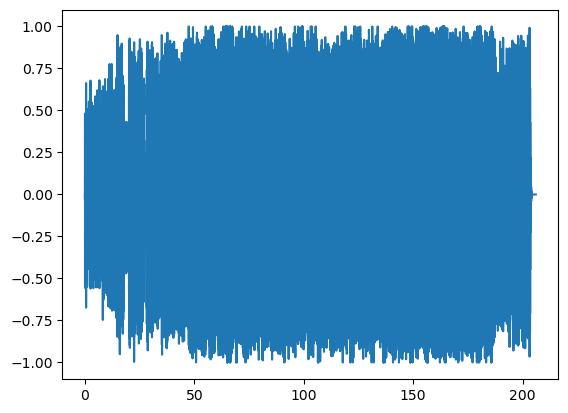

In [9]:
#plot signals
import matplotlib.pyplot as plt
#time axis
audio_plot = audio_data
audio_duration = len(audio_plot) / sample_rate
time = np.arange(0, audio_duration, 1/sample_rate)
left_plot = audio_plot[:, 0]
plt.plot(time, left_plot)

# Produce and save noised audio file

In [10]:
sf.write((file_name + " (noised).wav"), audio_data, sample_rate)

# Playback

In [11]:
import sounddevice as sd

In [ ]:
sd.play(audio_data, sample_rate)
sd.wait()

# Move files to top level to accomodate for fma large dataset file structure

In [1]:
import os
import shutil
main_dir = "/vol/bitbucket/al4624/finetune_dataset/fma_large"
# Walk through all subdirectories, move all audio files in them to the top level
for root, dirs, files in os.walk(main_dir):
    for file in files:
        if file.lower().endswith(".mp3"):
            src_path = os.path.join(root, file)
            dest_path = os.path.join(main_dir, file)
            shutil.move(src_path, dest_path)
#delete the empty subdirectories
for root, dirs, files in os.walk(main_dir, topdown=False):
   for dir in dirs:
        dir_path = os.path.join(root, dir)
        try:
            shutil.rmtree(dir_path)
        except Exception as e:
            print(f"Failed to remove {dir_path} with error: {e}")
        

print("Audio files moved successfully.")

Audio files moved successfully.


# Whole script, processes a list of tracks

In [9]:
import numpy as np
import time
import soundfile as sf
import os
from concurrent.futures import ThreadPoolExecutor
from functools import partial
from pathlib import Path
import shutil


def get_all_mp3_file_paths(dir_path):
    return [str(file) for file in Path(dir_path).rglob('*.flac') if file.is_file()] #NEED CHANGE TO MP3
#pre: both directories exist
dataset_folder_path = "finetune_dataset/example_music"
noised_dataset_folder_path = "finetune_dataset/example_music_noised"

#read input files as np array, assuming audio is stereo
file_names = get_all_mp3_file_paths(dataset_folder_path)

signal_weight = 0.1

def stereo_to_mono(stereo_data):
    return stereo_data.mean(axis=1)
    
def noise_gen_gaussian(range_factor, frame_count):
    mean = 0.0
    #portion of values in range = 1 - 1 / range_factor^2
    #value range is 1 here
    std = 1.0 / range_factor
    
    # Gaussian noise: create a random normal distribution that has the same size as the data to add noise to 
    # Genearte noise with same size as that of the data.
    return np.random.normal(mean, std, frame_count)

#signal weight controls how much of the audio signal we want to keep
def add_noise(audio_data, noise_data, signal_weight):
    audio_data *= signal_weight
    audio_data += noise_data * (1.0 - signal_weight)

def noise_file(file_name, signal_weight):
    try:
        #each sample value is from -1 to 1
        audio_data, sample_rate = sf.read(file_name)
        #mono conversion - YuE only supports mono audio
        audio_data = stereo_to_mono(audio_data)
        frame_count = len(audio_data)
        #if training examples are of the same length, we can just calculate this once for the first training example
        #split to 3 segments: start, middle and end
        segment_frame_count = int(frame_count / 3)
        middle_segment_start = segment_frame_count
        middle_segment_end = segment_frame_count * 2
        audio_data_middle = audio_data[middle_segment_start : middle_segment_end]
        
        #Add the noise to the data
        #To save computation cost, we can also generate the noise only once, and then use slices of the same noise throughout training to accomodate
        #for different durations
        #range factor of 4 covers the dynmaic range quite well without clipping too much
        noise_data = noise_gen_gaussian(4, segment_frame_count)
        #0.9 signal weight for now, first finetune introduces only a small amount of noise 
        add_noise(audio_data_middle, noise_data, 0.9)
        
        #clip above and below, avoid out of range values
        np.clip(audio_data_middle, -1.0, 1.0, out = audio_data_middle)
        
        #save noised audio, same name since we store them in a different directory
        sf.write(os.path.join(noised_dataset_folder_path, os.path.basename(file_name)), audio_data, sample_rate)

        print(f"File {file_name} finished noising. Middle segement starts at {middle_segment_start / sample_rate}, ends at {middle_segment_end / sample_rate} ")
    #FMA dataset has corrupted files. It is normal for a few files to fail the processing.
    except Exception as e:
        print(f"Error processing {file_name}: {e}. Skipping")
        raise

def parallel_noising():
    if __name__ == "__main__":
        #ProcessPoolExecutor is probably faster, but we have file IO with soundfile, which will cause problem
        with ThreadPoolExecutor() as executor:
            futures = [
                executor.map(noise_file, file_names, [signal_weight] * len(file_names))
            ]

start = time.time()
#for file in file_names:
 #   noise_file(file, 0.9)
parallel_noising()
end = time.time()
elapsed = end - start
print(f"Processing took {elapsed:.2f} seconds.")


File finetune_dataset\example_music\29 - She's Out of My Life.flac finished noising. Middle segement starts at 65.23172335600907, ends at 130.46344671201814 
File finetune_dataset\example_music\26 - This Place Hotel.flac finished noising. Middle segement starts at 98.01619047619047, ends at 196.03238095238095 
File finetune_dataset\example_music\25 - Wanna Be Startin' Somethin'.flac finished noising. Middle segement starts at 106.90192743764172, ends at 213.80385487528343 
File finetune_dataset\example_music\27 - Another Part of Me.flac finished noising. Middle segement starts at 80.83727891156462, ends at 161.67455782312925 
File finetune_dataset\example_music\28 - I Just Can't Stop Loving You.flac finished noising. Middle segement starts at 87.868820861678, ends at 175.737641723356 
File finetune_dataset\example_music\12 - Don't Be Messin' 'Round.flac finished noising. Middle segement starts at 86.49616666666667, ends at 172.99233333333333 
File finetune_dataset\example_music\19 - Fl

In [2]:
00pip install soundfile

  Using cached soundfile-0.13.1-py2.py3-none-win_amd64.whl.metadata (16 kB)
  Using cached pycparser-2.22-py3-none-any.whl.metadata (943 bytes)
Using cached soundfile-0.13.1-py2.py3-none-win_amd64.whl (1.0 MB)
Using cached pycparser-2.22-py3-none-any.whl (117 kB)

   ---------------------------------------- 0/3 [pycparser]
   ---------------------------------------- 0/3 [pycparser]
   ------------- -------------------------- 1/3 [cffi]
   -------------------------- ------------- 2/3 [soundfile]
   ---------------------------------------- 3/3 [soundfile]

Note: you may need to restart the kernel to use updated packages.
